# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [2]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-09-19 16:48:26--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Распознаётся ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Подключение к ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 416 Requested Range Not Satisfiable

    Файл уже получен полностью; нет действий.

--2021-09-19 16:48:26--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Повторное использование соединения с ufldl.stanford.edu:80.
HTTP-запрос отправлен. Ожидание ответа... 416 Requested Range Not Satisfiable

    Файл уже получен полностью; нет действий.



In [3]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms
from pytorch_helper import PyTorchHelper

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [5]:
_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                         std=[0.20,0.20,0.20])                   
])

In [6]:
# First, lets load the dataset
data_train = dset.SVHN('./', transform=_transform)
data_test = dset.SVHN('./', split='test', transform=_transform)

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [7]:
batch_size = 64
helper = PyTorchHelper(batch_size,  data_train)

train_indices, val_indices = helper.split(.2)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [8]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [9]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [10]:
loss_history, train_history, val_history = helper.train_model('model_1', nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.397822, Train accuracy: 0.533853, Val accuracy: 0.741451
Average loss: 0.701356, Train accuracy: 0.787189, Val accuracy: 0.809023
Average loss: 0.595015, Train accuracy: 0.822373, Val accuracy: 0.824381
Average loss: 0.551818, Train accuracy: 0.834795, Val accuracy: 0.827111
Average loss: 0.521180, Train accuracy: 0.846483, Val accuracy: 0.828135


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [13]:
def print_augmentation(list_tfs):
    tfs = transforms.Compose(list_tfs)
    
    data_vis = dset.SVHN('./')
    data_aug_vis = dset.SVHN('./', transform=tfs)

    plt.figure(figsize=(30, 3))

    num_samples = 20

    for i, ((x, _), (x_aug, _)) in enumerate(zip(data_vis, data_aug_vis)):
        if i == num_samples:
            break
        plt.subplot(2, num_samples, i + 1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.grid(False)
        plt.imshow(x_aug)
        plt.axis('off')

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

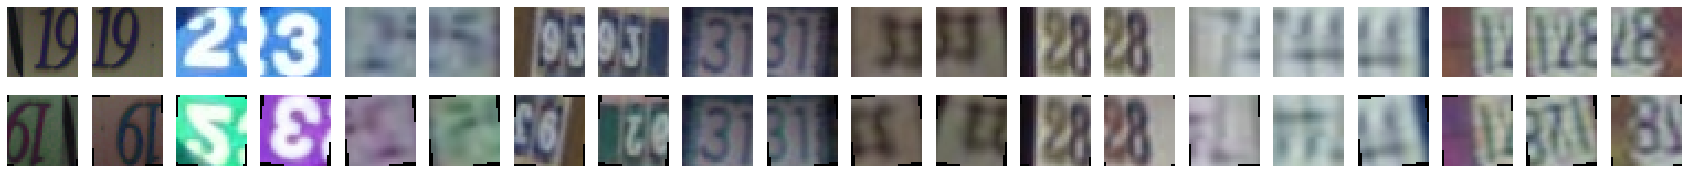

In [14]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

list_tfs = [
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
]
print_augmentation(list_tfs)

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

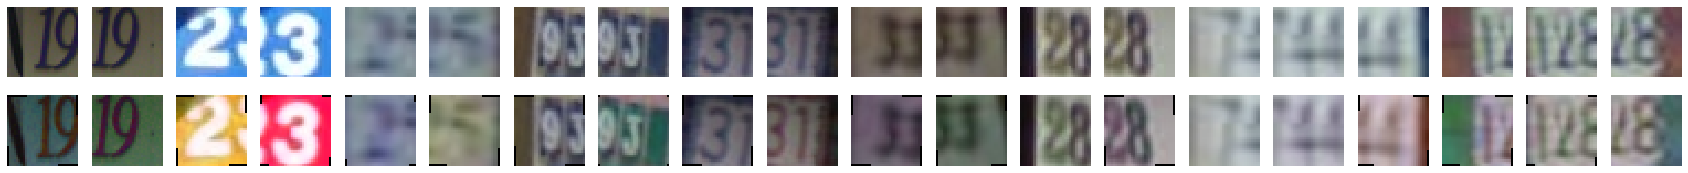

In [15]:
list_tfs = [
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(5, resample=PIL.Image.BILINEAR),
]
print_augmentation(list_tfs)

In [16]:
# TODO: 
list_tfs.append(transforms.ToTensor())
list_tfs.append(transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]))

tfs = transforms.Compose(list_tfs)

# TODO create new instances of loaders with the augmentations you chose

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [17]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = helper.train_model('model_2', nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.576010, Train accuracy: 0.826161, Val accuracy: 0.835370
Average loss: 0.528868, Train accuracy: 0.841689, Val accuracy: 0.851751
Average loss: 0.510081, Train accuracy: 0.846091, Val accuracy: 0.856938
Average loss: 0.496888, Train accuracy: 0.850698, Val accuracy: 0.840011
Average loss: 0.481474, Train accuracy: 0.854076, Val accuracy: 0.852843


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [13]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  
            
            Flattener(),

            nn.Linear(16*5*5, 120), 
            nn.ReLU(inplace=True),

            nn.Linear(120, 84),
            nn.ReLU(inplace=True),

            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = helper.train_model('lenet_base', lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.394986, Train accuracy: 0.525851, Val accuracy: 0.806020
Average loss: 0.555884, Train accuracy: 0.831331, Val accuracy: 0.836325
Average loss: 0.456112, Train accuracy: 0.862727, Val accuracy: 0.846632
Average loss: 0.404206, Train accuracy: 0.878357, Val accuracy: 0.875367
Average loss: 0.367298, Train accuracy: 0.889295, Val accuracy: 0.884035
Average loss: 0.338634, Train accuracy: 0.897894, Val accuracy: 0.877005
Average loss: 0.315994, Train accuracy: 0.904037, Val accuracy: 0.877892
Average loss: 0.295906, Train accuracy: 0.910641, Val accuracy: 0.892567
Average loss: 0.279231, Train accuracy: 0.915606, Val accuracy: 0.894342
Average loss: 0.264560, Train accuracy: 0.918575, Val accuracy: 0.890861


# Подбор гиперпараметров

In [15]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1]
anneal_coeff = 0.2
anneal_epochs = [5]
regs = [0.0001]
optimizers = [optim.SGD]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
from itertools import product

best_hyperparams = Hyperparams(None, None, None)
best_result = RunResult(None, None, None, None)

for lr, reg, anneal_epoch, optimizer in product(learning_rates, regs, anneal_epochs, optimizers):
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),

        nn.Conv2d(6, 16, 5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),  
            
        Flattener(),

        nn.Linear(16*5*5, 120), 
        nn.ReLU(inplace=True),

        nn.Linear(120, 84),
        nn.ReLU(inplace=True),

        nn.Linear(84, 10)
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

    optimizer = optimizer(lenet_model.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)
    
    params = Hyperparams(lr, anneal_epoch, reg)

    print(f"\nCurrent hyperparams: {params}")

    loss_history, train_history, val_history = helper.train_model('best_lenet',lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

    result = RunResult(lenet_model, train_history, val_history, val_history[-1])
    run_record[params] = result

    if best_result.final_val_accuracy is None or best_result.final_val_accuracy < result.final_val_accuracy:
        best_result = result
        best_hyperparams = params

    print("\nCurrent best validation accuracy: %4.2f, best hyperparams: %s" % (best_result.final_val_accuracy, best_hyperparams))


Current hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)
Average loss: 1.365539, Train accuracy: 0.533171, Val accuracy: 0.801584
Average loss: 0.545943, Train accuracy: 0.835256, Val accuracy: 0.830046
Average loss: 0.449788, Train accuracy: 0.864161, Val accuracy: 0.841240
Average loss: 0.401984, Train accuracy: 0.877828, Val accuracy: 0.868883
Average loss: 0.367627, Train accuracy: 0.890370, Val accuracy: 0.874480
Average loss: 0.270992, Train accuracy: 0.918711, Val accuracy: 0.895092
Average loss: 0.249622, Train accuracy: 0.925008, Val accuracy: 0.897891
Average loss: 0.236266, Train accuracy: 0.929222, Val accuracy: 0.897345
Average loss: 0.226930, Train accuracy: 0.933113, Val accuracy: 0.897208
Average loss: 0.221106, Train accuracy: 0.934051, Val accuracy: 0.898437

Current best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)


In [16]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [17]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [0.1]
anneal_coeff = 0.2
anneal_epochs = [5]
regs = [1e-4]
optimizers = [optim.SGD]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
from itertools import product

best_hyperparams = Hyperparams(None, None, None)
best_result = RunResult(None, None, None, None)

for lr, reg, anneal_epoch, optimizer in product(learning_rates, regs, anneal_epochs, optimizers):
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 60, 5),
        nn.BatchNorm2d(60),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),

        
        nn.Conv2d(60, 30, 5),
        nn.BatchNorm2d(30),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),  
            
        Flattener(),

        nn.Linear(30*5*5, 120), 
        nn.BatchNorm1d(120),
        nn.ReLU(inplace=True),

        nn.Linear(120, 84),
        nn.BatchNorm1d(84),
        nn.ReLU(inplace=True),

        nn.Linear(84, 10)
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

    optimizer = optimizer(lenet_model.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)
    
    params = Hyperparams(lr, anneal_epoch, reg)

    print(f"\nCurrent hyperparams: {params}")

    loss_history, train_history, val_history = helper.train_model('my_lenet', lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

    result = RunResult(lenet_model, train_history, val_history, val_history[-1])
    run_record[params] = result

    if best_result.final_val_accuracy is None or best_result.final_val_accuracy < result.final_val_accuracy:
        best_result = result
        best_hyperparams = params

    print("\nCurrent best validation accuracy: %4.2f, best hyperparams: %s" % (best_result.final_val_accuracy, best_hyperparams))


Current hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)
Average loss: 0.671161, Train accuracy: 0.790482, Val accuracy: 0.870589
Average loss: 0.405503, Train accuracy: 0.876327, Val accuracy: 0.889700
Average loss: 0.350003, Train accuracy: 0.894141, Val accuracy: 0.897481
Average loss: 0.309681, Train accuracy: 0.904498, Val accuracy: 0.890246
Average loss: 0.281369, Train accuracy: 0.913064, Val accuracy: 0.908334
Average loss: 0.214955, Train accuracy: 0.936423, Val accuracy: 0.918504
Average loss: 0.200966, Train accuracy: 0.941064, Val accuracy: 0.919186
Average loss: 0.188839, Train accuracy: 0.944084, Val accuracy: 0.921098
Average loss: 0.183918, Train accuracy: 0.945859, Val accuracy: 0.919664
Average loss: 0.175631, Train accuracy: 0.948077, Val accuracy: 0.918367

Current best validation accuracy: 0.92, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)


In [18]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.92, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [19]:
# TODO Write the code to compute accuracy on test set

best_model = best_result.model
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = helper.compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9107252612169637
